In [ ]:
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
#from keras.utils import to_categorical

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
m_train = X_train.shape[0]
m_test = X_test.shape[0]

In [ ]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)
Number of training examples: m_train = 60000
Number of testing examples: m_test = 10000


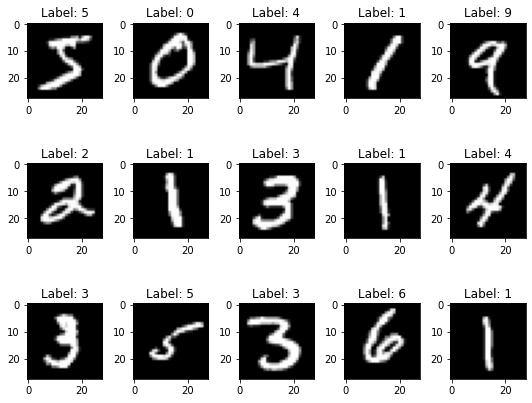

In [ ]:
num = 15
images = X_train[:num]
labels = y_train[:num]

num_row = 3
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Subsample the data
m_train = 50000
m_validation = 10000

mask = list(range(m_train, m_train + m_validation))
X_val = X_train[mask]
y_val = y_train[mask]

mask = list(range(m_train))
X_train = X_train[mask]
y_train = y_train[mask]

mask = list(range(m_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
# Reshape data to rows
X_train = X_train.reshape(m_train, -1)
X_val = X_val.reshape(m_validation, -1)
X_test = X_test.reshape(m_test, -1)

In [ ]:
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of validation examples: m_validation = " + str(m_validation))
print ("Number of testing examples: m_test = " + str(m_test))

X_train shape: (50000, 784)
y_train shape: (50000,)
X_val shape: (10000, 784)
y_val shape: (10000,)
X_test shape: (10000, 784)
y_test shape: (10000,)
Number of training examples: m_train = 50000
Number of validation examples: m_validation = 10000
Number of testing examples: m_test = 10000


In [ ]:
print("Feature Values: \nFrom " + str(np.min(X_train)) + " to " + str(np.max(X_train)))
print("Data type: " + str(X_train.dtype))
print("\nLabel Values: ")
print(set(list(y_train)))
print("Data type: " + str(y_train.dtype))

Feature Values: 
From 0 to 255
Data type: uint8

Label Values: 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Data type: uint8


In [ ]:
class DeepNeuralNetwork(object):    
   

    def __init__(self, input_size, hidden_size, output_size, std=1e-4): 
        
        self.params = {}    
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)  #Guassian Weight Initilliazation 
        self.params['b1'] = np.zeros((1, hidden_size))    
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)   
        self.params['b2'] = np.zeros((1, output_size))

    def loss(self, X, y=None):
        
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape
        
        # Compute the forward pass
        scores = None
        h1 = ReLU(np.dot(X, W1) + b1)      
        out = np.dot(h1, W2) + b2          
        scores = out
        
        # If the targets are not given then jump out, we're done
        if y is None:   
            return scores
        
        # Compute the loss
        scores_max = np.max(scores, axis=1, keepdims=True)    # (N,1)
        exp_scores = np.exp(scores - scores_max)              # (N,C)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)    # (N,C)
        correct_logprobs = -np.log(probs[range(N), y])        # (N,1)
        data_loss = np.sum(correct_logprobs) / N
        loss = data_loss 
        
        # Backward pass: compute gradients
        grads = {}
        dscores = probs                                 # (N,C)
        dscores[range(N), y] -= 1
        dscores /= N
        dW2 = np.dot(h1.T, dscores)                     # (H,C)
        db2 = np.sum(dscores, axis=0, keepdims=True)    # (1,C)
        dh1 = np.dot(dscores, W2.T)                     # (N,H)
        dh1[h1 <= 0] = 0
        dW1 = np.dot(X.T, dh1)                          # (D,H)
        db1 = np.sum(dh1, axis=0, keepdims=True)        # (1,H)
        dW2 +=  W2
        dW1 +=  W1
        
        grads['W1'] = dW1
        grads['b1'] = db1
        grads['W2'] = dW2
        grads['b2'] = db2

        return loss, grads

    def sgd(self, X, y, X_val, y_val, learning_rate=0.1, mu=0.9, num_epochs=30, 
               mu_increase=1.0, batch_size=16, verbose=False):   
        num_train = X.shape[0]
        iterations_per_epoch = max(int(num_train / batch_size), 1)
        
        # Use SGD to optimize the parameters in self.model
        v_W2, v_b2 = 0.0, 0.0
        v_W1, v_b1 = 0.0, 0.0
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(1, num_epochs * iterations_per_epoch + 1):   
            X_batch = None   
            y_batch = None 
            
            # Create a random minibatch of training data and labels
            sample_index = np.random.choice(num_train, batch_size, replace=True)   
            X_batch = X[sample_index, :]          
            y_batch = y[sample_index]             
            
            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch) 
            loss_history.append(loss)
            
            # Use the gradients to update the parameters of the network
            v_W2 = mu * v_W2 - (0.001)*learning_rate * grads['W2']    #If I don't multiply it with (0.0l) then it overflow the cost and it will be infinity
            self.params['W2'] += v_W2   
            v_b2 = mu * v_b2 - (0.001)*learning_rate * grads['b2']    
            self.params['b2'] += v_b2   
            v_W1 = mu * v_W1 - (0.001)*learning_rate * grads['W1']    
            self.params['W1'] += v_W1   
            v_b1 = mu * v_b1 - (0.001)*learning_rate * grads['b1']  
            self.params['b1'] += v_b1
            
            if verbose and it % iterations_per_epoch == 0:    
            # Every epoch, check train and val accuracy and decay learning rate.
                epoch = it / iterations_per_epoch    
                train_acc = (self.predict(X_batch) == y_batch).mean()    
                val_acc = (self.predict(X_val) == y_val).mean()    
                train_acc_history.append(train_acc)    
                val_acc_history.append(val_acc)    
                print("epoch %d / %d: loss %f, train_acc: %.2f, val_acc: %.2f" % 
                                    (epoch, num_epochs, loss, train_acc*100, val_acc*100))
                # print("epoch {0} / {1}: loss {2:.2}, train_acc: {3:.2}%, val_acc: {4:.2}%"
                # .format(epoch, num_epochs, loss, train_acc*100, val_acc*100))
        return {   
            'loss_history': loss_history,   
            'train_acc_history': train_acc_history,   
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):    
        y_pred = None    
        h1 = ReLU(np.dot(X, self.params['W1']) + self.params['b1'])    
        scores = np.dot(h1, self.params['W2']) + self.params['b2']    
        y_pred = np.argmax(scores, axis=1)    

        return y_pred

def ReLU(x):    
     
    return np.maximum(0, x)

In [ ]:
input_size = X_train.shape[1]
number_of_neurons = 15
num_classes = 10
net = DeepNeuralNetwork(input_size, number_of_neurons, num_classes)

# Train the network
stats = net.sgd(X_train, y_train, X_val, y_val, num_epochs=30, batch_size=16, learning_rate=0.1, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()

epoch 1 / 30: loss 0.216977, train_acc: 87.50, val_acc: 91.47
epoch 2 / 30: loss 0.297747, train_acc: 87.50, val_acc: 92.48
epoch 3 / 30: loss 0.335626, train_acc: 93.75, val_acc: 90.90
epoch 4 / 30: loss 0.160913, train_acc: 100.00, val_acc: 91.68
epoch 5 / 30: loss 0.117251, train_acc: 100.00, val_acc: 92.88
epoch 6 / 30: loss 0.060976, train_acc: 100.00, val_acc: 91.38
epoch 7 / 30: loss 0.084236, train_acc: 100.00, val_acc: 93.47
epoch 8 / 30: loss 0.089914, train_acc: 100.00, val_acc: 92.07
epoch 9 / 30: loss 0.158188, train_acc: 100.00, val_acc: 92.58
epoch 10 / 30: loss 0.741651, train_acc: 81.25, val_acc: 93.25
epoch 11 / 30: loss 0.556479, train_acc: 87.50, val_acc: 91.94
epoch 12 / 30: loss 0.501329, train_acc: 93.75, val_acc: 92.95
epoch 13 / 30: loss 0.571758, train_acc: 87.50, val_acc: 90.78
epoch 14 / 30: loss 0.226479, train_acc: 93.75, val_acc: 92.89
epoch 15 / 30: loss 0.995952, train_acc: 81.25, val_acc: 92.96
epoch 16 / 30: loss 0.290554, train_acc: 93.75, val_acc: 9

In [ ]:
input_size = X_train.shape[1]
number_of_neurons = 30
num_classes = 10
net = DeepNeuralNetwork(input_size, number_of_neurons, num_classes)

# Train the network
stats = net.sgd(X_train, y_train, X_val, y_val, num_epochs=30, batch_size=16, learning_rate=0.1, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()

epoch 1 / 30: loss 0.464299, train_acc: 87.50, val_acc: 93.29
epoch 2 / 30: loss 0.089175, train_acc: 100.00, val_acc: 93.56
epoch 3 / 30: loss 0.158055, train_acc: 93.75, val_acc: 93.75
epoch 4 / 30: loss 0.221170, train_acc: 93.75, val_acc: 94.09
epoch 5 / 30: loss 0.112414, train_acc: 100.00, val_acc: 93.90
epoch 6 / 30: loss 0.187047, train_acc: 93.75, val_acc: 94.89
epoch 7 / 30: loss 0.229883, train_acc: 93.75, val_acc: 92.67
epoch 8 / 30: loss 0.644632, train_acc: 75.00, val_acc: 93.68
epoch 9 / 30: loss 0.315015, train_acc: 93.75, val_acc: 94.19
epoch 10 / 30: loss 0.309960, train_acc: 93.75, val_acc: 94.09
epoch 11 / 30: loss 0.294219, train_acc: 93.75, val_acc: 92.67
epoch 12 / 30: loss 0.136309, train_acc: 100.00, val_acc: 94.08
epoch 13 / 30: loss 0.086658, train_acc: 100.00, val_acc: 94.02
epoch 14 / 30: loss 0.486598, train_acc: 81.25, val_acc: 94.58
epoch 15 / 30: loss 0.404540, train_acc: 93.75, val_acc: 94.45
epoch 16 / 30: loss 0.243700, train_acc: 93.75, val_acc: 93.

In [ ]:
input_size = X_train.shape[1]
number_of_neurons = 100
num_classes = 10
net = DeepNeuralNetwork(input_size, number_of_neurons, num_classes)

# Train the network
stats = net.sgd(X_train, y_train, X_val, y_val, num_epochs=30, batch_size=16, learning_rate=0.1, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()

epoch 1 / 30: loss 0.119488, train_acc: 100.00, val_acc: 95.17
epoch 2 / 30: loss 0.401736, train_acc: 93.75, val_acc: 95.10
epoch 3 / 30: loss 0.324690, train_acc: 87.50, val_acc: 94.94
epoch 4 / 30: loss 0.457343, train_acc: 93.75, val_acc: 94.94
epoch 5 / 30: loss 0.398190, train_acc: 93.75, val_acc: 94.81
epoch 6 / 30: loss 0.055973, train_acc: 100.00, val_acc: 94.54
epoch 7 / 30: loss 0.149566, train_acc: 93.75, val_acc: 95.15
epoch 8 / 30: loss 0.121703, train_acc: 100.00, val_acc: 92.42
epoch 9 / 30: loss 0.171165, train_acc: 100.00, val_acc: 94.72
epoch 10 / 30: loss 0.203961, train_acc: 93.75, val_acc: 95.24
epoch 11 / 30: loss 0.132897, train_acc: 100.00, val_acc: 94.53
epoch 12 / 30: loss 0.062387, train_acc: 100.00, val_acc: 93.77
epoch 13 / 30: loss 0.443374, train_acc: 81.25, val_acc: 94.94
epoch 14 / 30: loss 0.114882, train_acc: 100.00, val_acc: 94.45
epoch 15 / 30: loss 0.102362, train_acc: 100.00, val_acc: 93.51
epoch 16 / 30: loss 0.455809, train_acc: 87.50, val_acc:

In [ ]:
input_size = X_train.shape[1]
number_of_neurons = 15
num_classes = 10
net = DeepNeuralNetwork(input_size, number_of_neurons, num_classes)

# Train the network
stats = net.sgd(X_train, y_train, X_val, y_val, num_epochs=30, batch_size=16, learning_rate=3, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()

epoch 1 / 30: loss 2.291653, train_acc: 18.75, val_acc: 13.45
epoch 2 / 30: loss 2.300036, train_acc: 6.25, val_acc: 10.81
epoch 3 / 30: loss 2.295210, train_acc: 12.50, val_acc: 10.64
epoch 4 / 30: loss 2.310828, train_acc: 6.25, val_acc: 10.64
epoch 5 / 30: loss 2.310065, train_acc: 0.00, val_acc: 10.64
epoch 6 / 30: loss 2.280495, train_acc: 18.75, val_acc: 10.64
epoch 7 / 30: loss 2.309698, train_acc: 6.25, val_acc: 10.64
epoch 8 / 30: loss 2.305693, train_acc: 12.50, val_acc: 10.64
epoch 9 / 30: loss 2.301159, train_acc: 18.75, val_acc: 10.64
epoch 10 / 30: loss 2.302282, train_acc: 12.50, val_acc: 10.64
epoch 11 / 30: loss 2.287161, train_acc: 12.50, val_acc: 10.64
epoch 12 / 30: loss 2.306737, train_acc: 12.50, val_acc: 10.64
epoch 13 / 30: loss 2.315824, train_acc: 6.25, val_acc: 10.64
epoch 14 / 30: loss 2.308013, train_acc: 6.25, val_acc: 10.64
epoch 15 / 30: loss 2.305474, train_acc: 12.50, val_acc: 10.64
epoch 16 / 30: loss 2.292878, train_acc: 12.50, val_acc: 10.64
epoch 1

In [ ]:
input_size = X_train.shape[1]
number_of_neurons = 30
num_classes = 10
net = DeepNeuralNetwork(input_size, number_of_neurons, num_classes)

# Train the network
stats = net.sgd(X_train, y_train, X_val, y_val, num_epochs=30, batch_size=16, learning_rate=3, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()

epoch 1 / 30: loss 2.265183, train_acc: 6.25, val_acc: 18.66
epoch 2 / 30: loss 2.294943, train_acc: 18.75, val_acc: 10.64
epoch 3 / 30: loss 2.313710, train_acc: 6.25, val_acc: 10.64
epoch 4 / 30: loss 2.317898, train_acc: 6.25, val_acc: 10.64
epoch 5 / 30: loss 2.302397, train_acc: 6.25, val_acc: 10.64
epoch 6 / 30: loss 2.333757, train_acc: 0.00, val_acc: 10.64
epoch 7 / 30: loss 2.298450, train_acc: 6.25, val_acc: 10.64
epoch 8 / 30: loss 2.297930, train_acc: 12.50, val_acc: 10.64
epoch 9 / 30: loss 2.301337, train_acc: 18.75, val_acc: 10.64
epoch 10 / 30: loss 2.288761, train_acc: 12.50, val_acc: 10.64
epoch 11 / 30: loss 2.276757, train_acc: 18.75, val_acc: 10.64
epoch 12 / 30: loss 2.282093, train_acc: 12.50, val_acc: 10.64
epoch 13 / 30: loss 2.286111, train_acc: 18.75, val_acc: 10.64
epoch 14 / 30: loss 2.321711, train_acc: 6.25, val_acc: 10.64
epoch 15 / 30: loss 2.280249, train_acc: 25.00, val_acc: 10.64
epoch 16 / 30: loss 2.304233, train_acc: 6.25, val_acc: 10.64
epoch 17 

In [ ]:
input_size = X_train.shape[1]
number_of_neurons = 100
num_classes = 10
net = DeepNeuralNetwork(input_size, number_of_neurons, num_classes)

# Train the network
stats = net.sgd(X_train, y_train, X_val, y_val, num_epochs=30, batch_size=16, learning_rate=3, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()

epoch 1 / 30: loss 2.311781, train_acc: 12.50, val_acc: 9.83
epoch 2 / 30: loss 2.337117, train_acc: 0.00, val_acc: 10.64
epoch 3 / 30: loss 2.301099, train_acc: 12.50, val_acc: 10.64
epoch 4 / 30: loss 2.315803, train_acc: 6.25, val_acc: 10.64
epoch 5 / 30: loss 2.316912, train_acc: 0.00, val_acc: 10.64
epoch 6 / 30: loss 2.337483, train_acc: 0.00, val_acc: 10.64
epoch 7 / 30: loss 2.297614, train_acc: 25.00, val_acc: 10.64
epoch 8 / 30: loss 2.296008, train_acc: 12.50, val_acc: 10.64
epoch 9 / 30: loss 2.301826, train_acc: 6.25, val_acc: 10.64
epoch 10 / 30: loss 2.290018, train_acc: 18.75, val_acc: 10.64
epoch 11 / 30: loss 2.327474, train_acc: 0.00, val_acc: 10.64
epoch 12 / 30: loss 2.308888, train_acc: 12.50, val_acc: 10.64
epoch 13 / 30: loss 2.316986, train_acc: 6.25, val_acc: 10.64
epoch 14 / 30: loss 2.308292, train_acc: 6.25, val_acc: 10.64
epoch 15 / 30: loss 2.314663, train_acc: 0.00, val_acc: 10.64
epoch 16 / 30: loss 2.266255, train_acc: 31.25, val_acc: 10.64
epoch 17 / 

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers


# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [ ]:
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(15, kernel_size=(3, 3), activation="sigmoid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
       # layers.Conv2D(64, kernel_size=(3, 3), activation="sigmoid"),
       # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
       # layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


In [ ]:
batch_size = 16
epochs = 30
optimizer = keras.optimizers.Adam(lr=0.1)


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


In [ ]:
batch_size = 16
epochs = 30
optimizer = keras.optimizers.Adam(lr=0.1)
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(30, kernel_size=(3, 3), activation="sigmoid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
       # layers.Conv2D(64, kernel_size=(3, 3), activation="sigmoid"),
       # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
       # layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

In [ ]:
batch_size = 16
epochs = 30
optimizer = keras.optimizers.Adam(lr=0.1)
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(100, kernel_size=(3, 3), activation="sigmoid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
       # layers.Conv2D(64, kernel_size=(3, 3), activation="sigmoid"),
       # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
       # layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

In [ ]:
batch_size = 16
epochs = 30
optimizer = keras.optimizers.Adam(lr=0.3)
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(15, kernel_size=(3, 3), activation="sigmoid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
       # layers.Conv2D(64, kernel_size=(3, 3), activation="sigmoid"),
       # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
       # layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

In [ ]:
batch_size = 16
epochs = 30
optimizer = keras.optimizers.Adam(lr=0.3)
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(30, kernel_size=(3, 3), activation="sigmoid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
       # layers.Conv2D(64, kernel_size=(3, 3), activation="sigmoid"),
       # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
       # layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

In [ ]:
batch_size = 16
epochs = 30
optimizer = keras.optimizers.Adam(lr=0.3)
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(100, kernel_size=(3, 3), activation="sigmoid"),
        layers.MaxPooling2D(pool_size=(2, 2)),
       # layers.Conv2D(64, kernel_size=(3, 3), activation="sigmoid"),
       # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
       # layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()